# Part C – Programming Task (Python / Jupyter Notebook)
1. Implement A* search on a maze (given as a 2D matrix where 1=wall, 0=path, A=start,
B=goal).
- Use Manhattan distance as heuristic.
- Visualize the path found.

2. Modify the heuristic:
- Case 1: Multiply Manhattan distance by 1.5 (check if it is admissible).
- Case 2: Define heuristic so that for one edge it violates consistency.
3. For each case, run A* and record:
- Path found
- Cost of path
- Whether the path is optimal

In [2]:
import heapq
import copy
import numpy as np
import matplotlib.pyplot as plt

class MazeSolver:
    """
    A class to find a path through a maze using the A* search algorithm
    and provide visualizations of the solution and heuristics.
    """

    def __init__(self, maze):
        """
        Initializes the MazeSolver with a given maze.

        Args:
            maze (list[list]): A 2D list representing the maze where 'A' is the start,
                               'B' is the goal, 1 is a wall, and 0 is an open path.
        """
        if not maze:
            raise ValueError("Input maze cannot be empty.")
        self.original_maze = copy.deepcopy(maze)
        self.processed_maze, self.start, self.goal = self._process_maze()
        if not self.start or not self.goal:
            raise ValueError("Maze must contain a start ('A') and a goal ('B').")

    def _process_maze(self):
        """
        Converts the maze to numeric values and identifies start and goal positions.
        'A' and 'B' are treated as walkable paths (0).

        Returns:
            tuple: A tuple containing the processed maze (list[list]),
                   the start coordinates (tuple), and the goal coordinates (tuple).
        """
        processed = []
        start_pos, goal_pos = None, None
        for r, row in enumerate(self.original_maze):
            new_row = []
            for c, cell in enumerate(row):
                if cell == 'A':
                    start_pos = (r, c)
                    new_row.append(0)
                elif cell == 'B':
                    goal_pos = (r, c)
                    new_row.append(0)
                else:
                    new_row.append(cell)
            processed.append(new_row)
        return processed, start_pos, goal_pos

    # --- Heuristic Definitions ---
    @staticmethod
    def manhattan_heuristic(a, b):
        """Standard Manhattan distance. This is admissible and consistent."""
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    @staticmethod
    def weighted_manhattan_heuristic(a, b):
        """Manhattan distance multiplied by 1.5. This is inadmissible."""
        return (abs(a[0] - b[0]) + abs(a[1] - b[1])) * 1.5

    def inconsistent_heuristic(self, a, b):
        """
        Violates consistency for a specific edge.
        For point (1,1), it gives an artificially low value.
        Let n=(0,1) and n'=(1,1). cost(n,n')=1.
        h(n) = manhattan((0,1), goal) = 21
        h(n') = 1 (artificially low)
        Consistency requires h(n) <= cost(n,n') + h(n').
        21 <= 1 + 1  (21 <= 2) is FALSE. Thus, it is inconsistent.
        """
        if a == (1, 1):
            return 1  # Artificially low value to create inconsistency
        return self.manhattan_heuristic(a, b)

    def _get_neighbors(self, pos):
        """
        Gets the valid, walkable neighbors of a given position in the maze.

        Args:
            pos (tuple): The current position (row, col).

        Returns:
            list[tuple]: A list of neighbor coordinates.
        """
        neighbors = []
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, Down, Left, Right
        rows, cols = len(self.processed_maze), len(self.processed_maze[0])
        for dr, dc in directions:
            nr, nc = pos[0] + dr, pos[1] + dc
            if 0 <= nr < rows and 0 <= nc < cols and self.processed_maze[nr][nc] != 1:
                neighbors.append((nr, nc))
        return neighbors

    def solve_with_a_star(self, heuristic_func):
        """
        Finds the path from 'A' to 'B' using the A* search algorithm.

        Args:
            heuristic_func (function): The heuristic function to use for the search.

        Returns:
            list[tuple]: The path from start to goal as a list of coordinates,
                         or an empty list if no path is found.
        """
        came_from = {}
        g_score = {self.start: 0}
        f_score = {self.start: heuristic_func(self.start, self.goal)}
        
        priority_queue = [(f_score[self.start], self.start)]

        while priority_queue:
            _, current = heapq.heappop(priority_queue)

            if current == self.goal:
                return self._reconstruct_path(came_from, current)

            for neighbor in self._get_neighbors(current):
                tentative_g_score = g_score.get(current, float('inf')) + 1

                if tentative_g_score < g_score.get(neighbor, float('inf')):
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + heuristic_func(neighbor, self.goal)
                    if (f_score[neighbor], neighbor) not in priority_queue:
                        heapq.heappush(priority_queue, (f_score[neighbor], neighbor))
        
        print("No path found.")
        return []

    def _reconstruct_path(self, came_from, current):
        """Helper function to trace the path back from the goal."""
        total_path = [current]
        while current in came_from:
            current = came_from[current]
            total_path.insert(0, current)
        return total_path

    def get_path_visualization(self, path):
        """
        Marks a given path on the maze for visualization in text format.
        """
        maze_copy = copy.deepcopy(self.original_maze)
        for r, c in path:
            if (r, c) != self.start and (r, c) != self.goal:
                maze_copy[r][c] = '*'
        return maze_copy

    @staticmethod
    def print_matrix(matrix):
        """
        Prints a matrix (maze, path) in a readable text format.
        """
        for row in matrix:
            row_str = ""
            for val in row:
                if isinstance(val, str):
                    row_str += f" {val} "
                else:
                    row_str += f"{val:2d} "
            print(row_str)
        print()

    def visualize_path_with_plot(self, path, title="A* Path Visualization"):
        """
        Visualizes the maze and the found path using matplotlib.
        
        Args:
            path (list[tuple]): The path to visualize.
            title (str): The title for the plot.
        """
        maze_np = np.array(self.processed_maze, dtype=int)
        
        plt.figure(figsize=(8, 8))
        # Use cmap='binary' to have walls (1) be black and paths (0) be white
        plt.imshow(maze_np, cmap="binary", interpolation='nearest')
        
        if path:
            # Extract row (y) and column (x) coordinates from the path
            y_coords, x_coords = zip(*path)
            plt.plot(x_coords, y_coords, marker="o", color="red", linewidth=2, label="Path")

        # Mark start and goal points
        plt.scatter(self.start[1], self.start[0], color="green", s=200, label="A (Start)", zorder=5, edgecolors='black')
        plt.scatter(self.goal[1], self.goal[0], color="blue", s=200, label="B (Goal)", zorder=5, edgecolors='black')
        
        # Configure grid and axes
        ax = plt.gca()
        ax.set_xticks(np.arange(0, maze_np.shape[1], 1))
        ax.set_yticks(np.arange(0, maze_np.shape[0], 1))
        ax.set_xticks(np.arange(-.5, maze_np.shape[1], 1), minor=True)
        ax.set_yticks(np.arange(-.5, maze_np.shape[0], 1), minor=True)
        ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5)
        
        plt.legend()
        plt.title(title)
        plt.show()




Part 1: A* Search with Standard Manhattan Heuristic
Path Found: [(0, 0), (0, 1), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (6, 4), (6, 5), (5, 5), (5, 6), (5, 7), (6, 7), (6, 8), (6, 9), (7, 9), (8, 9), (8, 10), (8, 11), (9, 11), (10, 11), (11, 11)]

Cost of Path: 24

Is Path Optimal? Yes.
Analysis: Standard Manhattan distance is admissible and consistent, guaranteeing an optimal path.


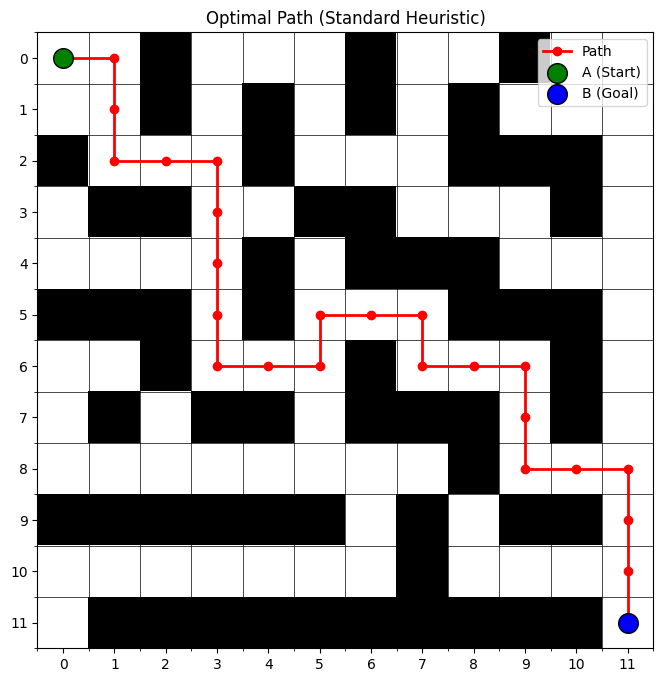



Part 2, Case 1: A* with Inadmissible Heuristic (h * 1.5)
Path Found: [(0, 0), (0, 1), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (6, 4), (6, 5), (5, 5), (5, 6), (5, 7), (6, 7), (6, 8), (6, 9), (7, 9), (8, 9), (8, 10), (8, 11), (9, 11), (10, 11), (11, 11)]

Cost of Path: 24

Is Path Optimal? Not guaranteed. In this case, the path is longer (suboptimal).
Analysis: An inadmissible heuristic overestimates cost, sacrificing the guarantee of optimality for a potentially faster search.


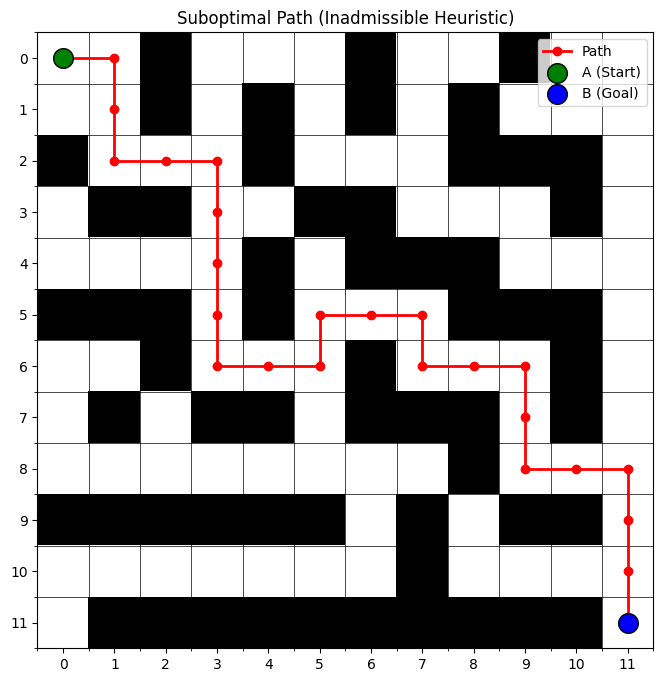



Part 2, Case 2: A* with Inconsistent Heuristic
Path Found: [(0, 0), (0, 1), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (6, 4), (6, 5), (5, 5), (5, 6), (5, 7), (6, 7), (6, 8), (6, 9), (7, 9), (8, 9), (8, 10), (8, 11), (9, 11), (10, 11), (11, 11)]

Cost of Path: 24

Is Path Optimal? Yes, but potentially less efficient.
Analysis: A* with an admissible but inconsistent heuristic is still guaranteed to find the optimal path but may expand more nodes.


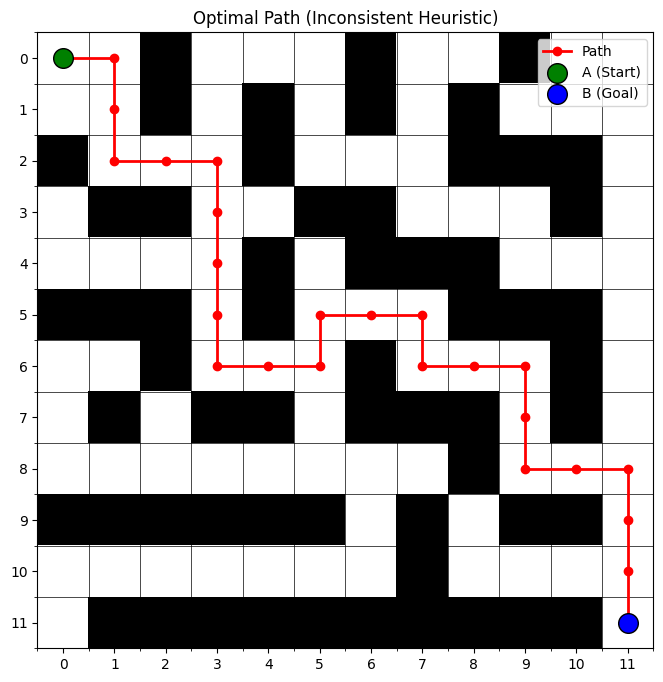

In [3]:
if __name__ == '__main__':
    maze = [
        ['A', 0,  1,  0,  0,  0, 1, 0, 0, 1, 0, 0],
        [0,   0,  1,  0,  1,  0, 1, 0, 1, 0, 0, 0],
        [1,   0,  0,  0,  1,  0, 0, 0, 1, 1, 1, 0],
        [0,   1,  1,  0,  0,  1, 1, 0, 0, 0, 1, 0],
        [0,   0,  0,  0,  1,  0, 1, 1, 1, 0, 0, 0],
        [1,   1,  1,  0,  1,  0, 0, 0, 1, 1, 1, 0],
        [0,   0,  1,  0,  0,  0, 1, 0, 0, 0, 1, 0],
        [0,   1,  0,  1,  1,  0, 1, 1, 1, 0, 1, 0],
        [0,   0,  0,  0,  0,  0, 0, 0, 1, 0, 0, 0],
        [1,   1,  1,  1,  1,  1, 0, 1, 0, 1, 1, 0],
        [0,   0,  0,  0,  0,  0, 0, 1, 0, 0, 0, 0],
        [0,   1,  1,  1,  1,  1, 1, 1, 1, 1, 1,'B'],
    ]

    solver = MazeSolver(maze)
    
    # --- Part 1 ---
    print("="*60)
    print("Part 1: A* Search with Standard Manhattan Heuristic")
    print("="*60)
    path_1 = solver.solve_with_a_star(solver.manhattan_heuristic)
    if path_1:
        print(f"Path Found: {path_1}")
        print(f"\nCost of Path: {len(path_1) - 1}")
        print("\nIs Path Optimal? Yes.")
        print("Analysis: Standard Manhattan distance is admissible and consistent, guaranteeing an optimal path.")
        solver.visualize_path_with_plot(path_1, "Optimal Path (Standard Heuristic)")

    # --- Part 2, Case 1 ---
    print("\n" * 2 + "="*60)
    print("Part 2, Case 1: A* with Inadmissible Heuristic (h * 1.5)")
    print("="*60)
    path_2 = solver.solve_with_a_star(solver.weighted_manhattan_heuristic)
    if path_2:
        print(f"Path Found: {path_2}")
        print(f"\nCost of Path: {len(path_2) - 1}")
        print("\nIs Path Optimal? Not guaranteed. In this case, the path is longer (suboptimal).")
        print("Analysis: An inadmissible heuristic overestimates cost, sacrificing the guarantee of optimality for a potentially faster search.")
        solver.visualize_path_with_plot(path_2, "Suboptimal Path (Inadmissible Heuristic)")
        
    # --- Part 2, Case 2 ---
    print("\n" * 2 + "="*60)
    print("Part 2, Case 2: A* with Inconsistent Heuristic")
    print("="*60)
    path_3 = solver.solve_with_a_star(solver.inconsistent_heuristic)
    if path_3:
        print(f"Path Found: {path_3}")
        print(f"\nCost of Path: {len(path_3) - 1}")
        print("\nIs Path Optimal? Yes, but potentially less efficient.")
        print("Analysis: A* with an admissible but inconsistent heuristic is still guaranteed to find the optimal path but may expand more nodes.")
        solver.visualize_path_with_plot(path_3, "Optimal Path (Inconsistent Heuristic)")

